# TekKredi Machine Learning Challenge - Credit Scoring
#### Ozan Bekir Bulum

<a id='contents'></a>
## Contents
* [Introduction](#introduction)
  * [Problem Statement & Goal of the Project](#statement)
  * [Data Summary](#data_summary)
* [EDA](#eda)
  * [Reading Data](#reading_data)
  * [Tables](#tables)   
    * [Application Table](#application)
    * [Bureau Table](#bureau)
    * [Bureau Balance Table](#bureau_balance)
    * [Previous Application Table](#previous_application)
    * [Pos Cash Balance](#pos_cash_balance)
    * [Install Payments Table](#install_payments) 
    * [Credit Card Balance](#credit_card_balance) 
* [Feature Engineering](#f_e)
  * [Existing Feature Selection](#existing_feature_selection) 
    * [Application Table Feature Selection](#existing_feature_selection_application) 
  * [New Feature Creation](#new_featues)
    * [Application Table New Feature Creation](#new_featues_application)
    * [Bureau and Bureau Balance Table New Feature Creation](#new_featues_bureau)
    * [Previous Application Table New Feature Creation](#new_featues_previous-application) 
    * [Pos Cash Table New Feature Creation](#new_featues_pos_cash) 
    * [Credit Card Table New Feature Creation](#new_featues_credit_card_balance)   
    * [Installement Payments Table New Feature Creation](#new_featues_install_payments)
* [Modeling](#modeling)
  * [Create Feature Dataset](#feature_set)
  * [Model Evolution](#model_evo)
    * [LightGBM](#lightgbm)
  * [Predicting Test Set and Create Submission](#test_set) 
* [Final Words](#final_words)
  * [Summary of the Results](#summary_result) 
  * [Future Work](#future) 
    
    

## <a id='intoduction'>Introduction</a><br> 

### <a id='statement'>Problem Statement & Goal of the Project</a><br> 

Home Credit Group is an international consumer finance provider. Company offers sales finance through consumer finance to branch-enabled lending. Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.Company specializes in providing loans to people that have low exposure to banking services. 

   Home Credit Group's Kaggle Challenge is to predict how capable each applicant is of repaying a loan. Submission evaluated on area under the ROC curve between the predicted probability and the observed target. The goal of the challenge is to ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.
   
Data can be downloaded from [Kaggle Challenge's webpage](https://www.kaggle.com/c/home-credit-default-risk/data).



### <a id='data_summary'>Data Summary</a><br> 

The dataset is provided with 7 tables, also a column description table is included . ID of loans ("SK_ID_PREV" and "SK_ID_CURR") are primary keys, tables are connected to each other with those key.




![tables](home_credit_tables.png "Tables")

##  <a id='eda'>EDA</a><br>  
[Back to Contents](#contents)

###  <a id='reading_data'>Reading Data</a><br>  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("husl")
sns.set_style("whitegrid")
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import matplotlib.gridspec as gridspec
import gc
from sklearn.preprocessing import LabelEncoder

In [42]:
%%time
# Reading application table (main table)
application = pd.read_csv("../Home_Credit_Default_Risk/data/application_train.csv")
test = pd.read_csv("../Home_Credit_Default_Risk/data/application_test.csv")


CPU times: user 6.47 s, sys: 252 ms, total: 6.72 s
Wall time: 6.47 s


In [3]:
%%time
# Reading bureau table 

bureau = pd.read_csv("../Home_Credit_Default_Risk/data/bureau.csv")

CPU times: user 3.35 s, sys: 200 ms, total: 3.55 s
Wall time: 3.4 s


In [4]:
%%time
# Reading bureau balance table 

bureau_balance = pd.read_csv("../Home_Credit_Default_Risk/data/bureau_balance.csv")

CPU times: user 6.75 s, sys: 827 ms, total: 7.58 s
Wall time: 6.87 s


In [5]:
%%time
# Reading previous application table 

previous_application = pd.read_csv("../Home_Credit_Default_Risk/data/previous_application.csv")

CPU times: user 8.93 s, sys: 380 ms, total: 9.31 s
Wall time: 9.08 s


In [6]:
%%time
# Reading Pos Cash

POS_CASH_balance = pd.read_csv("../Home_Credit_Default_Risk/data/POS_CASH_balance.csv") 

CPU times: user 6.28 s, sys: 555 ms, total: 6.84 s
Wall time: 6.69 s


In [7]:
%%time
# Reading install payments table 
install_pay = pd.read_csv("../Home_Credit_Default_Risk/data/installments_payments.csv")

CPU times: user 10.6 s, sys: 1.04 s, total: 11.7 s
Wall time: 11.4 s


In [8]:
%%time
# Reading credit card balance table 
credit_card_balance = pd.read_csv("../Home_Credit_Default_Risk/data/credit_card_balance.csv")

CPU times: user 9.05 s, sys: 703 ms, total: 9.76 s
Wall time: 9.35 s


###  <a id='tables'>Tables</a><br>  

#### Pandas Profiling

"pandas_profiling" library is used to take a quick look to each dataset. This package generates quantile and descriptive statistics reports for each columns, quite handy for EDA in limited times.

In [11]:
import pandas_profiling

###  <a id='application'>Application Table</a><br>  
[Back to Contents](#contents)

### Summary with Profile Report

In [1]:
#pandas_profiling.ProfileReport(application)

### Checking Correlations with Target Variables

In [35]:
#Most positively correlated features with Target
cor_app_tgt = application.corr()['TARGET'].sort_values()
cor_app_tgt.head()

EXT_SOURCE_3    -0.178919
EXT_SOURCE_2    -0.160472
EXT_SOURCE_1    -0.155317
DAYS_EMPLOYED   -0.044932
FLOORSMAX_AVG   -0.044003
Name: TARGET, dtype: float64

In [37]:
#Most negatively correlated features with Target
cor_app_tgt.drop('TARGET', axis=0).tail()

DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
Name: TARGET, dtype: float64

### Table Summary

#### General
* Described as main table, "application" table has 122 features (1 ID (primary key), 73 numerical , 16 categorical, 33 boolean) including "TARGET" variable 
* This table has customer personel (count of children,house,car,enquiries,occupation ...) and credit  features (annuities, credit amount, time of application..)
* "TARGET" variable distribution shows that it's an unbalanced class problem ( %92 vs %8)
* Number of enquiries to Credit Bureau about the client is presented with different time period in dataset.
* No interest rate is given for loans
* 3 Different Credit Scores provided from external sources are available in dataset (e.g. EXT_SOURCE_2). 
* "CODE_GENDER" has 4 XNA Value

#### Missing Values
* 67 columns has missing values
* Multiple columns have +%50 rates of missing values. Most of them are about customer's home or car details.
* Family details (no of children, has not any missing values )
* Credit and income amounts have no missing values.

#### Outliers
* Credit amount distribution is highly skewed but no anomaly has been detected. (min :45K (230 entry), max: 4,050M (8 entry). Those are problably min and max credit limits.
* Days Employed feature has negative values and 55374 entries are fixed with 365243 (1000 years).This may be flagged later.

#### Correlations
* Some of variables are highly correlated with each others. Most of them are normalized same feature (such as appartment size) normalized with differeent adjustment.
* 3 Credit Scores (EXT_SOURCE) are negative correlated with target variables which means high credit score customers tend to  pay their credit better. They seem to be best feature to explain target variable.
* Client's age (DAYS_BIRTH) is the most positevely correlated variable in the dataset. 

###  <a id='bureau'>Bureau Table</a><br>
[Back to Contents](#contents)

### Summary with Profile Report

In [2]:
#pandas_profiling.ProfileReport(bureau)

### Checking Correlations with Target Variables

In [135]:
bureau.join(application[["SK_ID_CURR", "TARGET"]], 
            on="SK_ID_CURR", how="left", lsuffix="left")\
            .corr()['TARGET'].sort_values()\
            .drop(['TARGET', "SK_ID_CURR", "SK_ID_CURRleft"], axis=0).head()

DAYS_CREDIT              -0.002040
DAYS_ENDDATE_FACT        -0.001633
SK_ID_BUREAU             -0.001371
AMT_CREDIT_MAX_OVERDUE   -0.000044
CREDIT_DAY_OVERDUE       -0.000012
Name: TARGET, dtype: float64

In [136]:
bureau.join(application[["SK_ID_CURR", "TARGET"]],
            on="SK_ID_CURR", how="left", lsuffix="left")\
            .corr()['TARGET'].sort_values()\
            .drop(['TARGET', "SK_ID_CURR", "SK_ID_CURRleft"], axis=0).tail()

DAYS_CREDIT_ENDDATE    0.000478
AMT_CREDIT_SUM_DEBT    0.000823
AMT_CREDIT_SUM         0.000918
CNT_CREDIT_PROLONG     0.001294
AMT_ANNUITY            0.002440
Name: TARGET, dtype: float64

### Table Summary

#### General
* All client's previous credits provided by other financial institutions that were reported to Credit Bureau.
* Table has 17 features (2 ID,  12 numerical , 3 categorical)
* "AMT_ANNUITY"  is the monthly payment (interest rate included). This is info at application time as some clients can change their annuity which you would see in the other tables (balance and payment tables)

#### Missing Values
* There is no missing value on this table.
* 6 columns has missing values
* DAYS_CREDIT_ENDDATE column has %37 rates of missing values which is the rate of open credits in the time of application.
* "AMT_ANNUITY" feature has %71,5 missing value rate.

#### Outliers
*  "AMT_ANNUITY" has maximum value up to 118,5m

#### Correlations

* There is no significant  correlation between given features and "TARGET" variable.

###  <a id='bureau_balance'>Bureau Balance Table</a><br>  
[Back to Contents](#contents)

### Summary with Profile Report

In [3]:
#pandas_profiling.ProfileReport(bureau_balance)

### Table Summary

#### General
* Monthly balances of previous credits in Credit Bureau.
* Table has 3 features (1 ID, 1 numerical , 1 categorical)


#### Missing Values
* This table has no missing values.


#### Outliers
* No outlier observed

#### Correlations
* Since there is one feature categorical column ("STATUS") and it's montly table we cannot find any correlation

###  <a id='previous_application'>Previous Application Table</a><br>  
[Back to Contents](#contents)

### Summary with Profile Report

In [4]:
#pandas_profiling.ProfileReport(previous_application)

#### Checking Correlations with Target Variables

In [144]:

previous_application.join(application[["SK_ID_CURR","TARGET"]],
                          on="SK_ID_CURR", how="left", lsuffix="left")\
                          .corr()['TARGET'].sort_values()\
                          .drop(['TARGET', "SK_ID_CURR", "SK_ID_CURRleft"],
                          axis=0).head()

AMT_DOWN_PAYMENT            -0.002420
NFLAG_LAST_APPL_IN_DAY      -0.002381
NFLAG_INSURED_ON_APPROVAL   -0.002330
AMT_GOODS_PRICE             -0.001557
AMT_ANNUITY                 -0.001201
Name: TARGET, dtype: float64

In [145]:
previous_application.join(application[["SK_ID_CURR","TARGET"]],
                          on="SK_ID_CURR", how="left", lsuffix="left").corr()\
                          ['TARGET'].sort_values()\
                          .drop(['TARGET', "SK_ID_CURR", "SK_ID_CURRleft"],
                                axis=0).tail()

DAYS_TERMINATION           0.001293
DAYS_LAST_DUE              0.001901
DAYS_FIRST_DUE             0.002010
HOUR_APPR_PROCESS_START    0.002229
RATE_INTEREST_PRIMARY      0.004645
Name: TARGET, dtype: float64

### Table Summary

#### General
* All previous applications for loans of clients who have loans in application.There is one row for each previous application related to loans.
* Table has 36 features (2 ID, 18 numerical , 16 categorical, 1 Boolean)
* This table has interest rates.


#### Missing Values
* 12 columns has missing values
* %96 of Interest Rates values are missing


#### Outliers
* AMT_CREDIT and AMT_APPLICATION has 6,9M limits which is quite higher then application table's.

#### Correlations
* As expected AMT_CREDIT is highly correlated with AMT_APPLICATION.
* AMT_GOODS_PRICE is highly correlated with AMT_CREDIT which is also quite expected.
* RATE_INTEREST_PRIMARY is most correlated feature with "TARGET" variable bu most of them is missing


###  <a id='pos_cash_balance'>Pos Cash Balance Table</a><br>  
[Back to Contents](#contents)

### Summary with Profile Report

In [5]:
#pandas_profiling.ProfileReport(POS_CASH_balance)

### Table Summary

#### General
* Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had.
* Table has 8 features (2 ID, 5 numerical , 1 categorical)
* We can allocate "Day past dues" and contact status during months for given loans in this table.


#### Missing Values
* 2 columns have %0,3 missing values.


#### Outliers
* No outlier observed

#### Correlations
* None

###  <a id='install_payments'>Install Payments Table</a><br>
[Back to Contents](#contents)

#### Summary with Profile Report

In [6]:
#pandas_profiling.ProfileReport(install_pay)

#### Total Installement and Payed Amounts

Since it's a monthly tables  to be able to calculate feature correlation with "TARGET" variable we will group by sum of payments and installement of previous loans and check if Total amounts are correlated with "TARGET"

In [103]:
install_pay_sum = install_pay.groupby(['SK_ID_PREV', 'SK_ID_CURR'])\
                            ["AMT_INSTALMENT", "AMT_PAYMENT"]\
                            .apply(lambda x : x.sum())

install_pay_sum.join(application[["SK_ID_CURR", "TARGET"]], on="SK_ID_CURR",
                     how="left", lsuffix="left")\
                     .corr()['TARGET'].sort_values()\
                     .drop(['TARGET', "SK_ID_CURR"],axis=0).head()

#### Maximum installement number

In [125]:
#Taking last number of installement showing how many installement are made on previous applications.
qty_payments = install_pay[['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER']]\
                          .groupby(['SK_ID_CURR', 'SK_ID_PREV'], as_index=False)\
                          .agg({'NUM_INSTALMENT_NUMBER':'max'})
qty_payments.join(application[["SK_ID_CURR", "TARGET"]],
                  on="SK_ID_CURR", how="left", lsuffix="left")\
                  .corr()['TARGET'].sort_values()\
                  .drop(['TARGET', "SK_ID_CURR", "SK_ID_CURRleft", "SK_ID_PREV"]
                        ,axis=0).head()

NUM_INSTALMENT_NUMBER   -0.000751
Name: TARGET, dtype: float64

### Table Summary

#### General
* Repayment history for the previously disbursed credits related to the loans. OThere is a) one row for every payment that was made plus b) one row each for missed payment.
* Table has 8 features (2 ID,  6 numerical , 16 categorical)
* "NUM_INSTALMENT_VERSION" columns gives rank of endorsement; change of installment version from month to month signifies that some parameter of payment calendar has changed 


#### Missing Values
* There is no missing value on this table.


#### Outliers
* Installements and credit payments has some outliers (up to 3.200000). 

#### Correlations
* Naturally "AMT_PAYMENT" is highly correlated with "AMT_INSTALMENT", we may create new features using  those features.
* There is no significant  correlation between Total Installements, Payed Amounts and "TARGET" variable
* There is no significant  correlation between installement count and "TARGET" variable 

#### Checking outlier

In [83]:
install_pay[install_pay["SK_ID_PREV"]==1562725]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
9119046,1562725,399624,2.0,1,-770.0,-787.0,3202061.805,3202061.805


3202061805 seems to much for an installement but it's a single installement for a loan. Since 4.050000 is loan limit, this amount is acceptable

###  <a id='credit_card_balance'>Credit Card Balance Table</a><br>  
[Back to Contents](#contents)

#### Summary with Profile Report

In [7]:
#pandas_profiling.ProfileReport(credit_card_balance)

### Table Summary

#### General
* Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans)
* Table has 23 features (2 ID, 20 numerical , 1 categorical)


#### Missing Values
* 8 columns have  missing values. Those columns are payment and drawning column which means there might be no payment or drawings.


#### Outliers
* No outlier observed

#### Correlations
* AMT_PAYMENT_TOTAL_CURRENT is highly correlated with AMT_PAYMENT_CURRENT as expected. For most month those have same values.

## <a id='f_e'>Feature Engineering</a><br>  
[Back to Contents](#contents)

### <a id='existing_feature_selection'>Existing Feature Selection</a><br>  



To select raw features from static table (application), we will use feature selection process using target permutation tests actual importance significance against the distribution of feature importances when fitted to noise (shuffled target). 

Reference : 
[Feature Selection with Null Importances](https://www.kaggle.com/ogrellier/feature-selection-with-null-importances).

### <a id='existing_feature_selection_application'>Application Table Feature Selection</a>  



In [43]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import gc
gc.enable()

In [44]:
data=application.copy()
id_target=['TARGET', 'SK_ID_CURR',"test"]

categorical_feats = [f for f in data.columns if data[f].dtype == 'object']

for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')    

Defining a function giving feature importance of datasets using LightGBM feature_importance function

In [47]:
def get_feature_importances(data, shuffle, seed=None, id_target_=id_target):
    # Gather real features
    categorical_feats = [f for f in data.columns if data[f].dtype == 'object']
    
    for f_ in categorical_feats:
        data[f_], _ = pd.factorize(data[f_])
        # Set feature type as categorical
        data[f_] = data[f_].astype('category')
      
    train_features = [f for f in data if f not in id_target]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y,
                         free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200,
                    categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df


In [48]:
categorical_feats = [f for f in data.columns if data[f].dtype == 'object']

categorical_feats
for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')

Getting feature importance dataset using all rows

In [37]:
%%time
actual_imp_df = get_feature_importances(data, shuffle=False, seed=1)

CPU times: user 1min 43s, sys: 2.57 s, total: 1min 46s
Wall time: 33.3 s


Create multiple shuffled importance dataset to make comparaison and decrease randomness chances

In [22]:
%%time
null_imp_df = pd.DataFrame()
nb_runs = 8
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=application, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)


CPU times: user 9min 34s, sys: 17.4 s, total: 9min 51s
Wall time: 2min 42s


Getting feature "importance gain" and "importance split" score dataframes for both null and actual importance (not shuffled).

In [23]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f,
                                       'importance_gain'].values
    
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f,
                                        'importance_gain'].mean()
    
    gain_score = np.log(1e-10 + f_act_imps_gain /
                        (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f,
                                        'importance_split'].values
    
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f,
                                         'importance_split'].mean()
    
    split_score = np.log(1e-10 + f_act_imps_split /
                         (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores,
                         columns=['feature', 'split_score', 'gain_score'])

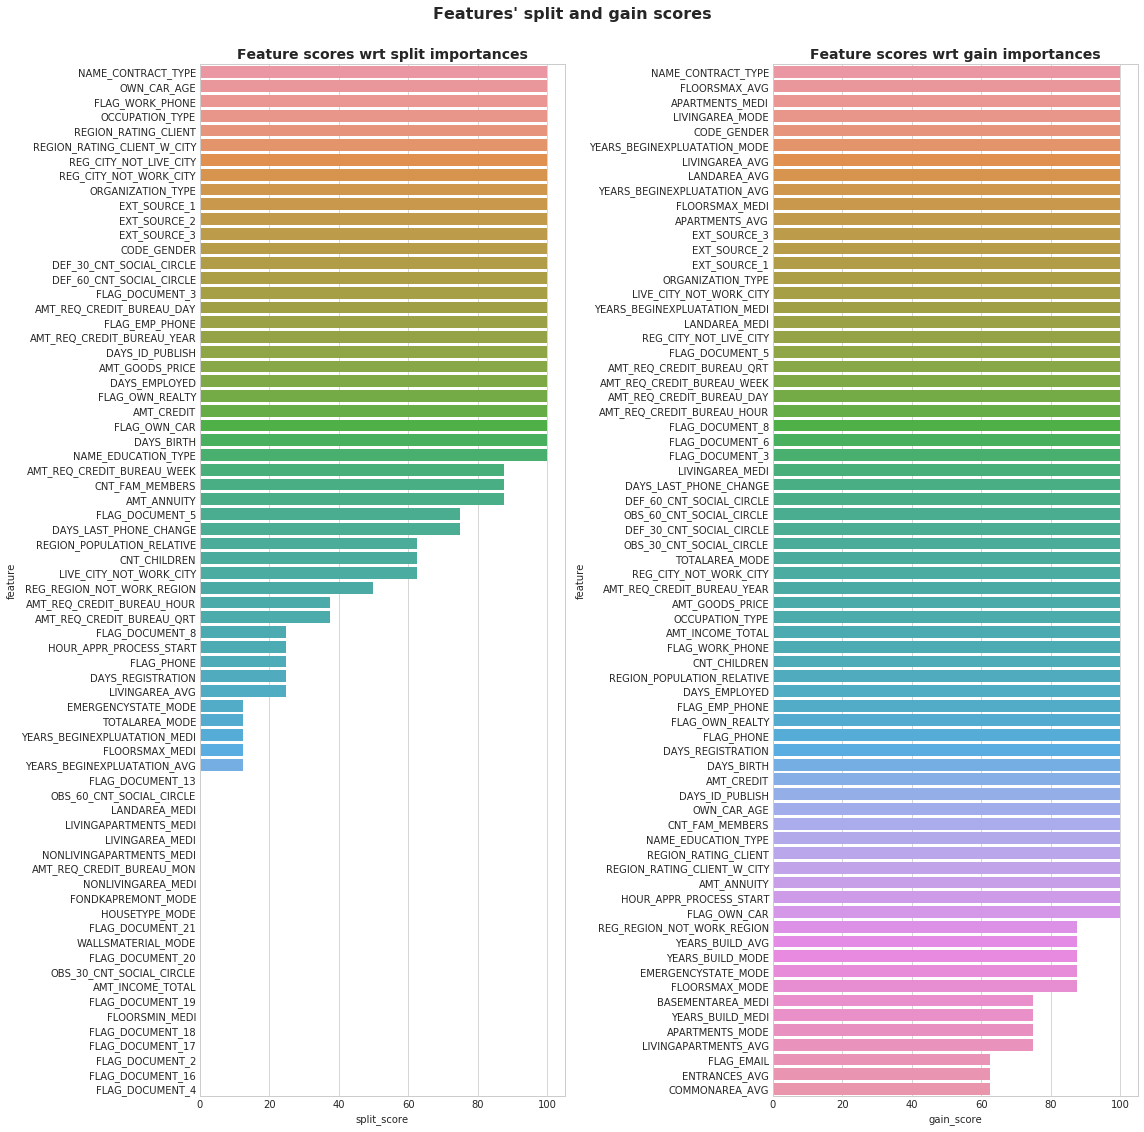

In [24]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f,
                                  'importance_gain'].values
    
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f,
                                   'importance_gain'].values
    
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25))\
                 .sum() / f_null_imps.size
    
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f,
                                  'importance_split'].values
    
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f,
                                   'importance_split'].values
    
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25))\
                  .sum() / f_null_imps.size
    
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores,
                              columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature',
            data=corr_scores_df.sort_values('split_score',
                                            ascending=False).iloc[0:70], ax=ax)

ax.set_title('Feature scores wrt split importances',
             fontweight='bold', fontsize=14)

# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature',
            data=corr_scores_df.sort_values('gain_score',
                                            ascending=False).iloc[0:70], ax=ax)

ax.set_title('Feature scores wrt gain importances',
             fontweight='bold', fontsize=14)

plt.tight_layout()

plt.suptitle("Features' split and gain scores",
             fontweight='bold', fontsize=16)

fig.subplots_adjust(top=0.93)

In [32]:
def score_feature_selection(df=None, train_features=None,
                            cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target,
                         free_raw_data=False, silent=True)
    
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]


for threshold in [0, 10, 40,60]:
    split_feats = [_f for _f, _score, _ in correlation_scores
                   if _score >= threshold]
    
    split_cat_feats = [_f for _f, _score, _ in correlation_scores
                       if (_score >= threshold) & (_f in categorical_feats)]
    
    gain_feats = [_f for _f, _, _score in correlation_scores
                  if _score >= threshold]

    gain_cat_feats = [_f for _f, _, _score in correlation_scores if
                      (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=data,
                                            train_features=split_feats,
                                            cat_feats=split_cat_feats,
                                            target=data['TARGET'])
    
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    
    gain_results = score_feature_selection(df=data, train_features=gain_feats,
                                           cat_feats=gain_cat_feats,
                                           target=data['TARGET'])
    
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))


Results for threshold   0
	 SPLIT : 0.756421 +/- 0.001794
	 GAIN  : 0.756421 +/- 0.001794
Results for threshold  10
	 SPLIT : 0.756286 +/- 0.001043
	 GAIN  : 0.756073 +/- 0.001235
Results for threshold  40
	 SPLIT : 0.755614 +/- 0.001448
	 GAIN  : 0.755525 +/- 0.001039
Results for threshold  60
	 SPLIT : 0.756132 +/- 0.001524
	 GAIN  : 0.755536 +/- 0.001591


We can use 60 threshold to select features from application table.

In [67]:
split_feats = [_f for _f, _score, _ in correlation_scores if _score >= 60]
len(split_feats)

35

In [68]:
id_target = ['SK_ID_CURR'] #to add test data set with selected features

#### Creating Test Model

In [69]:
split_feats.extend(id_target)

In [70]:
test_model = test[test.columns.intersection(split_feats)]

In [71]:
# Adittionally add "TARGET" variable to train feature dataset
id_target_2=['TARGET']

In [72]:
split_feats.extend(id_target_2)

In [73]:
#creating application table model with selected features only 
application_model = application[application.columns.intersection(split_feats)]

### <a id='new_featues'>New Feature Creation</a><br>  

[Back to Contents](#contents)

Since tables (other than Application Table) has many entry for a single SK_ID_CURR (one to many relationship with Application Table ) we will take max and mean values of features.


Reference:[Fork_of_ForK_LightGBM_with_Simple_Features]("https://www.kaggle.com/poohtls/fork-of-fork-lightgbm-with-simple-features/code")

Than we will create new features for tables.


### <a id='new_featues_application'>Application Table New Feature Creation</a><br>  

[Back to Contents](#contents)


We will add new features for application test dataset and application train dataset (application_model)

#### New Credit to Annuity Ratio
It's not interest rate but gives an idea

In [74]:
application_model['NEW_CREDIT_TO_ANNUITY_RATIO'] = application_model['AMT_CREDIT'] / application_model['AMT_ANNUITY']
test_model['NEW_CREDIT_TO_ANNUITY_RATIO'] = application_model['AMT_CREDIT'] / application_model['AMT_ANNUITY']


#### Income Per Child

In [75]:
application['NEW_INC_PER_CHLD'] = application['AMT_INCOME_TOTAL'] / (1 + application['CNT_CHILDREN'])
test['NEW_INC_PER_CHLD'] = application['AMT_INCOME_TOTAL'] / (1 + application['CNT_CHILDREN'])


In [76]:
NEW_INC_PER_CHLD=application[['SK_ID_CURR','NEW_INC_PER_CHLD']]

application_model= application_model.merge(NEW_INC_PER_CHLD,
                                           on = ['SK_ID_CURR'], how = 'left')
del NEW_INC_PER_CHLD

In [77]:
NEW_INC_PER_CHLD=test[['SK_ID_CURR','NEW_INC_PER_CHLD']]

test_model= test_model.merge(NEW_INC_PER_CHLD, on = ['SK_ID_CURR'], how = 'left')
del NEW_INC_PER_CHLD

#### Organisation Median Income

In [78]:
income_by_org = application[['AMT_INCOME_TOTAL','ORGANIZATION_TYPE']]\
                           .groupby('ORGANIZATION_TYPE').median()\
                           ['AMT_INCOME_TOTAL']

application_model['NEW_INC_BY_ORG'] = application_model['ORGANIZATION_TYPE']\
                                                       .map(income_by_org)

test_model['NEW_INC_BY_ORG'] = test_model['ORGANIZATION_TYPE'].map(income_by_org)
del income_by_org

#### External Source Feature

Since Best raw parameters on application table is External Sources, creating new parameter using those may help the model

In [79]:
application_model['NEW_EXT_SOURCE'] = application_model['EXT_SOURCE_1'] * application_model['EXT_SOURCE_2'] * application_model['EXT_SOURCE_3']
test_model['NEW_EXT_SOURCE'] = test_model['EXT_SOURCE_1'] * test_model['EXT_SOURCE_2'] * test_model['EXT_SOURCE_3']

#### Credit to Income Ratio

In [80]:
application['NEW_CREDIT_TO_INCOME_RATIO'] = application['AMT_CREDIT'] / application['AMT_INCOME_TOTAL']
NEW_CREDIT_TO_INCOME_RATIO = application[['SK_ID_CURR','NEW_CREDIT_TO_INCOME_RATIO']]

application_model = application_model.merge(NEW_CREDIT_TO_INCOME_RATIO,
                                            on = ['SK_ID_CURR'], how = 'left')
del NEW_CREDIT_TO_INCOME_RATIO

In [81]:
test['NEW_CREDIT_TO_INCOME_RATIO'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
NEW_CREDIT_TO_INCOME_RATIO=test[['SK_ID_CURR', 'NEW_CREDIT_TO_INCOME_RATIO']]

test_model= test_model.merge(NEW_CREDIT_TO_INCOME_RATIO,
                             on = ['SK_ID_CURR'], how = 'left')
del NEW_CREDIT_TO_INCOME_RATIO

### <a id='new_featues_bureau'>Bureau and Bureau Balance Table New Feature Creation</a><br>  

[Back to Contents](#contents)


In [82]:
# one_hot_encoder for categorical values
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns,
                        dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

#### Creating Simple Calculated Features from Present Features

In [83]:
bureau_model = bureau.copy(deep=True)
bb_model = bureau_balance.copy(deep=True)

In [84]:
bb_model, bb_model_cat = one_hot_encoder(bb_model)
bureau_model, bureau_model_cat = one_hot_encoder(bureau_model)

In [85]:
bb_model_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_model_cat:
    bb_model_aggregations[col] = ['mean']
bb_model_agg = bb_model.groupby('SK_ID_BUREAU').agg(bb_model_aggregations)
bb_model_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_model_agg.columns.tolist()])
bureau_model = bureau_model.join(bb_model_agg, how='left', on='SK_ID_BUREAU')
bureau_model.drop(['SK_ID_BUREAU'], axis=1, inplace= True)


Creating aggregations for extra features

In [86]:
%%time
num_aggregations = {
        'DAYS_CREDIT': [ 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': [ 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': [ 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
# Bureau and bureau_balance categorical features
cat_aggregations = {}
for cat in bureau_model_cat: cat_aggregations[cat] = ['mean']
for cat in bb_model_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
bureau_agg = bureau_model.groupby('SK_ID_CURR')\
                         .agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

# Bureau: Active credits - using only numerical aggregations
active = bureau_model[bureau_model['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
del active, active_agg
gc.collect()

# Bureau: Closed credits - using only numerical aggregations
closed = bureau_model[bureau_model['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg


CPU times: user 8.38 s, sys: 3.96 s, total: 12.3 s
Wall time: 8.33 s


Now Creating new Features

#### Number of Past Loan per Customer 
Reference:[HOME CREDIT - BUREAU DATA - FEATURE ENGINEERING]("https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering")

In [87]:
bureau_loan_count= bureau[['SK_ID_CURR', 'DAYS_CREDIT']]\
                         .groupby(by=['SK_ID_CURR'])['DAYS_CREDIT']\
                         .count().reset_index()\
                         .rename(index=str,
                                 columns={'DAYS_CREDIT': 'BUREAU_LOAN_COUNT'})

bureau_agg = bureau_agg.merge(bureau_loan_count,
                              on=['SK_ID_CURR'], how='left')
del bureau_loan_count

#### Number of Types of Past Loans per Customer
Reference:[HOME CREDIT - BUREAU DATA - FEATURE ENGINEERING]("https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering")

In [88]:
bureau_number_of_types = bureau[['SK_ID_CURR', 'CREDIT_TYPE']]\
                               .groupby(by=['SK_ID_CURR'])\
                               ['CREDIT_TYPE'].nunique().reset_index()\
                               .rename(index=str,
                                       columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})

bureau_agg= bureau_agg.merge(bureau_number_of_types,
                             on=['SK_ID_CURR'], how='left')
del bureau_number_of_types

#### Average Number of Past Loans per Type per Customer
Is the Customer diversified in taking multiple types of Loan or Focused on a single type of loan?

Reference:[HOME CREDIT - BUREAU DATA - FEATURE ENGINEERING]("https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering")

In [89]:
# Number of Loans per Customer
grp = bureau[['SK_ID_CURR', 'DAYS_CREDIT']]\
            .groupby(by=['SK_ID_CURR'])['DAYS_CREDIT'].count().reset_index()\
                    .rename(index=str,
                            columns={'DAYS_CREDIT': 'BUREAU_LOAN_COUNT'})

bureau =bureau.merge(grp, on=['SK_ID_CURR'], how='left')

# Number of types of Credit loans for each Customer 
grp = bureau[['SK_ID_CURR', 'CREDIT_TYPE']]\
             .groupby(by=['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index()\
             .rename(index=str,
                     columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})

bureau = bureau.merge(grp, on=['SK_ID_CURR'], how='left')

bureau['AVERAGE_LOAN_TYPE'] = bureau['BUREAU_LOAN_COUNT']/bureau['BUREAU_LOAN_TYPES']

In [90]:
avg_loan_type = bureau[['SK_ID_CURR','AVERAGE_LOAN_TYPE']]
avg_loan_type.drop_duplicates("SK_ID_CURR", inplace=True)
bureau_agg= bureau_agg.merge(avg_loan_type, on=['SK_ID_CURR'], how='left')
del avg_loan_type

#### Average Number of Days Between Succesive Past Application for Each Customer
How often did the customer take credit in the past? Was it spaced out at regular time intervals - a signal of good financial planning OR were the loans concentrated around a smaller time frame - indicating potential financial trouble?

Reference:[HOME CREDIT - BUREAU DATA - FEATURE ENGINEERING]("https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering")

In [91]:
%%time
avg_days_succ_app = bureau[['SK_ID_CURR', 'SK_ID_BUREAU',
                            'DAYS_CREDIT']].groupby(by = ['SK_ID_CURR'])

avg_days_succ_app_1 = avg_days_succ_app.apply(lambda x:
                                              x.sort_values(['DAYS_CREDIT'],
                                                            ascending = False))\
                                               .reset_index(drop = True)

CPU times: user 1min 56s, sys: 1.31 s, total: 1min 57s
Wall time: 1min 58s


In [92]:
bureau_agg= bureau_agg.merge(avg_days_succ_app_1, on = ['SK_ID_CURR'], how = 'left')
del avg_days_succ_app,avg_days_succ_app_1 

#### Rate of Loans perCustomer Where End Date for Credit is past 

NEGATIVE VALUE - Credit date was in the past at time of application( May be bad sign )

POSITIVE VALUE - Credit date is in the future at time of application ( May be good sign)

Reference:[HOME CREDIT - BUREAU DATA - FEATURE ENGINEERING]("https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering")

In [93]:
bureau_model['CREDIT_ENDDATE_BINARY'] = bureau_model['DAYS_CREDIT_ENDDATE']

def f(x):
    if x<0:
        y = 0
    else:
        y = 1   
    return y

bureau_model['CREDIT_ENDDATE_BINARY'] = bureau_model.apply(lambda x: f(x.DAYS_CREDIT_ENDDATE), axis = 1)
print("New Binary Column calculated")

past_rate_loans= bureau_model\
                    .groupby(by=['SK_ID_CURR'])['CREDIT_ENDDATE_BINARY']\
                    .mean()\
                    .reset_index()\
                    .rename(index=str,
                            columns={'CREDIT_ENDDATE_BINARY': 'CREDIT_ENDDATE_PERCENTAGE'})


New Binary Column calculated


In [94]:
bureau_agg= bureau_agg.merge(past_rate_loans,
                             on=['SK_ID_CURR'], how='left')


#### Dept Over Credit Ratio

The Ratio of Total Debt to Total Credit for each Customer


Reference:[HOME CREDIT - BUREAU DATA - FEATURE ENGINEERING]("https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering")

In [95]:
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(0)

grp1 = bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM_DEBT']].groupby(by = ['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename( index = str, columns = { 'AMT_CREDIT_SUM_DEBT': 'TOTAL_CUSTOMER_DEBT'})
grp2 = bureau[['SK_ID_CURR', 'AMT_CREDIT_SUM']]\
             .groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM']\
             .sum()\
             .reset_index()\
             .rename(index=str,
                     columns={'AMT_CREDIT_SUM': 'TOTAL_CUSTOMER_CREDIT'})

bureau = bureau.merge(grp1, on=['SK_ID_CURR'], how='left')
bureau = bureau.merge(grp2, on=['SK_ID_CURR'], how='left')
del grp1, grp2

gc.collect()
bureau['DEBT_CREDIT_RATIO'] = bureau['TOTAL_CUSTOMER_DEBT']/bureau['TOTAL_CUSTOMER_CREDIT']

del bureau['TOTAL_CUSTOMER_DEBT'], bureau['TOTAL_CUSTOMER_CREDIT']

In [96]:
DEBT_CREDIT_RATIO=bureau[['SK_ID_CURR','DEBT_CREDIT_RATIO']]
DEBT_CREDIT_RATIO.drop_duplicates("SK_ID_CURR",inplace=True)
bureau_agg= bureau_agg.merge(DEBT_CREDIT_RATIO, on=['SK_ID_CURR'], how='left')
del DEBT_CREDIT_RATIO

#### Average Number of Loans Prolonged

Reference:[HOME CREDIT - BUREAU DATA - FEATURE ENGINEERING]("https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering")

In [97]:
bureau['CNT_CREDIT_PROLONG'] = bureau['CNT_CREDIT_PROLONG'].fillna(0)
avg_number_loan_prol = bureau[['SK_ID_CURR', 'CNT_CREDIT_PROLONG']]\
                          .groupby(by=['SK_ID_CURR'])['CNT_CREDIT_PROLONG']\
                          .mean().reset_index()\
                          .rename(index=str,
                                  columns={ 'CNT_CREDIT_PROLONG': 'AVG_CREDITDAYS_PROLONGED'})

In [98]:
bureau_agg= bureau_agg.merge(avg_number_loan_prol,
                             on=['SK_ID_CURR'], how='left')
del avg_number_loan_prol

### <a id='new_featues_previous-application'>Previous Application Table New Feature Creation</a><br>  


[Back to Contents](#contents)



#### Creating Simple Calculated Features from Present Features

In [99]:
%%time

previous_application, cat_cols = one_hot_encoder(previous_application,
                                                 nan_as_category=True)

previous_application['APP_CREDIT_PERC'] = previous_application['AMT_APPLICATION'] / previous_application['AMT_CREDIT']
num_aggregations = {
        'AMT_ANNUITY': [ 'max', 'mean'],
        'AMT_APPLICATION': [ 'max','mean'],
        'AMT_CREDIT': [ 'max', 'mean'],
        'APP_CREDIT_PERC': [ 'max', 'mean'],
        'AMT_DOWN_PAYMENT': [ 'max', 'mean'],
        'AMT_GOODS_PRICE': [ 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': [ 'max', 'mean'],
        'RATE_DOWN_PAYMENT': [ 'max', 'mean'],
        'DAYS_DECISION': [ 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']
    
previous_app_model = previous_application.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
#removing first level column names
previous_app_model.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in previous_app_model.columns.tolist()])

CPU times: user 28.9 s, sys: 14 s, total: 42.8 s
Wall time: 40 s


#### Creating New Features 

#### Previous Application Term of Last 3 Credits Mean

In [100]:
# Last 3 previous Credit dataset per customer
previous_application = previous_application\
                          .sort_values(['SK_ID_CURR', 'DAYS_DECISION'])
prev_applications_tail = previous_application\
                            .groupby(by=['SK_ID_CURR']).tail(3)

In [101]:
PREV_APP_TERM_3CREDIT_MEAN= prev_applications_tail\
                              .groupby(by=['SK_ID_CURR'])['CNT_PAYMENT']\
                              .mean().reset_index()

PREV_APP_TERM_3CREDIT_MEAN.rename(columns={'CNT_PAYMENT': 'PREV_APP_TERM_3CREDIT_MEAN'},
                        inplace=True)

In [102]:
previous_app_model = previous_app_model.merge(PREV_APP_TERM_3CREDIT_MEAN,
                                              on=['SK_ID_CURR'], how='left')
del PREV_APP_TERM_3CREDIT_MEAN

#### Previous Application Days Decision About Last 3 Credits Mean

In [103]:
PREV_APP_DAY_DEC_3CREDIT_MEAN = prev_applications_tail.groupby(by=['SK_ID_CURR'])['DAYS_DECISION']\
                                                      .mean().reset_index()

PREV_APP_DAY_DEC_3CREDIT_MEAN.rename(columns={
        'DAYS_DECISION': 'PREV_APP_DAY_DEC_3CREDIT_MEAN'}, inplace=True)

In [104]:
previous_app_model = previous_app_model\
                        .merge(PREV_APP_DAY_DEC_3CREDIT_MEAN,
                               on=['SK_ID_CURR'], how='left')

del PREV_APP_DAY_DEC_3CREDIT_MEAN

#### Previous Application Days First Drawing Last 3 Credits Mean

In [105]:
PREV_APP_DAY_FIRST_DRAW_3CREDIT_MEAN = prev_applications_tail\
                                         .groupby(by=['SK_ID_CURR'])\
                                          ['DAYS_FIRST_DRAWING']\
                                         .mean()\
                                         .reset_index()

PREV_APP_DAY_FIRST_DRAW_3CREDIT_MEAN.rename( columns={
        'DAYS_FIRST_DRAWING': 'PREV_APP_DAY_FIRST_DRAW_3CREDIT_MEAN'},
                        inplace=True)


In [106]:
previous_app_model = previous_app_model\
                        .merge(PREV_APP_DAY_FIRST_DRAW_3CREDIT_MEAN,
                               on=['SK_ID_CURR'], how='left')

del PREV_APP_DAY_FIRST_DRAW_3CREDIT_MEAN, prev_applications_tail

### <a id='new_featues_pos_cash'>Pos Cash Table New Feature Creation</a><br>  


[Back to Contents](#contents)


#### Creating Simple Calculated Features from Present Features

In [107]:
POS_CASH_balance_1 = POS_CASH_balance.copy()
POS_CASH_balance_1, cat_cols = one_hot_encoder(POS_CASH_balance_1)

In [108]:
aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
for cat in cat_cols:
    aggregations[cat] = ['mean']
    
pos_model = POS_CASH_balance_1.groupby('SK_ID_CURR').agg(aggregations)
pos_model.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_model.columns.tolist()])


#### Creating New Features 

#### Count of pos cash per customer

In [109]:
pos_model['POS_COUNT'] = POS_CASH_balance.groupby('SK_ID_CURR').size()

#### Count of Completed Loans per Customer

In [110]:
POS_CASH_balance['completed'] = POS_CASH_balance['NAME_CONTRACT_STATUS'] == 'Completed'
COUNT_COMPLETED_POS_CASH = POS_CASH_balance.groupby(['SK_ID_CURR'])\
                              ['completed'].sum().reset_index()


In [111]:
COUNT_COMPLETED_POS_CASH.rename(
                    columns={'completed': 'COUNT_COMPLETED_POS_CASH'},
                    inplace=True)
pos_model = pos_model.merge(COUNT_COMPLETED_POS_CASH, on=['SK_ID_CURR'], how='left')

In [112]:
del POS_CASH_balance_1,COUNT_COMPLETED_POS_CASH

### <a id='new_featues_credit_card_balance'>Credit Card Balance Table New Feature Creation</a><br>  


[Back to Contents](#contents)


In [113]:
credit_card_balance_1=credit_card_balance.copy()

#### Creating Simple Calculated Features from Present Features

In [114]:
credit_card_balance_1, cat_cols = one_hot_encoder(credit_card_balance_1)
    # General aggregations
credit_card_balance_1.drop(['SK_ID_PREV'], axis= 1, inplace = True)
credit_card_balance_model = credit_card_balance_1.groupby('SK_ID_CURR')\
                                                 .agg(['max', 'mean',
                                                       'sum', 'var'])

credit_card_balance_model.columns = pd.Index(['CC_' + e[0] + "_" + e[1]\
                                      .upper() for e in credit_card_balance_model.columns.tolist()])

#### Creating New Features 



#### Count of Entry per Customer

In [115]:
# Count credit card lines
credit_card_balance_model['CC_COUNT'] = credit_card_balance.groupby('SK_ID_CURR').size()

In [116]:
del credit_card_balance_1

### <a id='new_featues_install_payments'>Install Payments Table New Feature Creation</a><br>  


[Back to Contents](#contents)

#### Creating New Features 



#### Payment Percent Per Credit

In [117]:
install_pay_1 = install_pay.copy()

In [118]:
install_pay_1['PAYMENT_PERC'] = install_pay_1['AMT_PAYMENT'] / install_pay_1['AMT_INSTALMENT']


#### Rest of The Payment

In [119]:
install_pay_1['PAYMENT_DIFF'] = install_pay_1['AMT_INSTALMENT'] - install_pay_1['AMT_PAYMENT']

#### Days Past Due and Days Before Due

In [120]:
install_pay_1['DPD'] = install_pay_1['DAYS_ENTRY_PAYMENT'] - install_pay_1['DAYS_INSTALMENT']
install_pay_1['DBD'] = install_pay_1['DAYS_INSTALMENT'] - install_pay_1['DAYS_ENTRY_PAYMENT']
install_pay_1['DPD'] = install_pay_1['DPD'].apply(lambda x: x if x > 0 else 0)
install_pay_1['DBD'] = install_pay_1['DBD'].apply(lambda x: x if x > 0 else 0)

#### Creating Simple Calculated Features from Present Features

In [121]:
install_pay_1, cat_cols = one_hot_encoder(install_pay_1, nan_as_category= True)
aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': [ 'mean',  'var'],
        'PAYMENT_DIFF': [ 'mean', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
for cat in cat_cols:
    aggregations[cat] = ['mean']
install_pay_model = install_pay_1.groupby('SK_ID_CURR').agg(aggregations)
install_pay_model.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in install_pay_model.columns.tolist()])


In [122]:
del install_pay_1

## <a id='modeling'>Modeling</a><br>  


[Back to Contents](#contents)

### <a id='feature_set'>Create Feature Data Set</a><br>  


In [123]:
del POS_CASH_balance, application, bureau_balance, credit_card_balance, install_pay, previous_application

In [126]:
application_model.set_index('SK_ID_CURR', inplace=True)
test_model.set_index('SK_ID_CURR', inplace=True)

In [127]:
features = application_model.merge(install_pay_model,
                                   left_index=True, right_index=True,
                                   how="left")
features_test = test_model.merge(install_pay_model, left_index=True,
                                 right_index=True, how="left")

In [96]:
del application_model
del install_pay_model

In [128]:
features = features.merge(credit_card_balance_model, left_index=True,
                          right_index=True,how="left")
features_test = features_test.merge(credit_card_balance_model, left_index=True,
                                    right_index=True,how="left")


In [98]:
del credit_card_balance_model

In [129]:
features = features.merge(pos_model, left_index=True, right_index=True,
                          how="left")
features_test=features_test.merge(pos_model, left_index=True, right_index=True,
                                  how="left")


In [100]:
del pos_model

In [130]:
features = features.merge(previous_app_model, left_index=True,
                          right_index=True, how="left")

features_test=features_test.merge(previous_app_model, left_index=True,
                                  right_index=True, how="left")

In [102]:
del previous_app_model

In [131]:
features=features.merge(bureau_agg, left_index=True, right_index=True,
                        how="left")

features_test=features_test.merge(bureau_agg, left_index=True,
                                  right_index=True, how="left")

In [104]:
del bureau_agg

In [132]:
features=features.merge(previous_app_model, left_index=True,
                        right_index=True, how="left")
features_test=features_test.merge(previous_app_model, left_index=True,
                                  right_index=True, how="left")

In [116]:
del previous_app_model

In [133]:
features.shape

(307511, 665)

In [134]:
features_test.shape

(48744, 664)

In [135]:
#features.to_csv("features.csv", sep='\t')

In [136]:
#features_test.to_csv("features_test.csv", sep='\t')

### <a id='model_evo'>Model Evolution</a><br>  


[Back to Contents](#contents)

In [330]:
app_test=features_test

In [137]:
features['SK_ID_CURR'] = features.index

In [138]:
features_test['SK_ID_CURR'] = features_test.index

In [139]:
meta_cols = ['SK_ID_CURR']
meta_features = features[meta_cols]
features.drop(columns=meta_cols, inplace=True)

### <a id='lightgbm'>LightGBM</a>


[Back to Contents](#contents)

In [140]:
def process_dataframe(input_df, encoder_dict=None):
    """ Process a dataframe into a form useable by LightGBM """
    
    # Label encode categoricals
    print('Label encoding categorical features...')
    categorical_feats = input_df.columns[input_df.dtypes == 'object']
    for feat in categorical_feats:
        encoder = LabelEncoder()
        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
    print('Label encoding complete.')

    return input_df, categorical_feats.tolist(), encoder_dict

In [142]:
%%time
# LightGBM Model


import lightgbm as lgbm


# Process the data set.
features, categorical_feats, encoder_dict = process_dataframe(input_df=features)


# Separate into train and test
train_df = features
test_df = features_test


#the model 
target = train_df.pop('TARGET')
lgbm_train = lgbm.Dataset(data=train_df,
                          label=target,
                          categorical_feature=categorical_feats,
                          free_raw_data=False)

gc.collect()

lgbm_params = {
    'boosting': 'dart',
    'application': 'binary',
    'learning_rate': 0.1,
    'min_data_in_leaf': 30,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.5,
    'scale_pos_weight': 2,
    'drop_rate': 0.02
}
#Cross Validation Test
cv_results = lgbm.cv(train_set=lgbm_train,
                     params=lgbm_params,
                     nfold=5,
                     num_boost_round=500,
                     early_stopping_rounds=50,
                     verbose_eval=50,
                     metrics=['auc'])

optimum_boost_rounds = np.argmax(cv_results['auc-mean'])
print('Optimum boost rounds = {}'.format(optimum_boost_rounds))
print('Best CV result = {}'.format(np.max(cv_results['auc-mean'])))

clf = lgbm.train(train_set=lgbm_train,
                 params=lgbm_params,
                 num_boost_round=optimum_boost_rounds)

Label encoding categorical features...
Label encoding complete.
[50]	cv_agg's auc: 0.766985 + 0.00234617
[100]	cv_agg's auc: 0.77135 + 0.00214735
[150]	cv_agg's auc: 0.772671 + 0.00231059
[200]	cv_agg's auc: 0.773554 + 0.00230504
[250]	cv_agg's auc: 0.77474 + 0.0023899
[300]	cv_agg's auc: 0.775055 + 0.00237311
[350]	cv_agg's auc: 0.775481 + 0.00219765
[400]	cv_agg's auc: 0.775659 + 0.00212032
[450]	cv_agg's auc: 0.775813 + 0.00195205
Optimum boost rounds = 445
Best CV result = 0.7758476070664334
CPU times: user 56min 52s, sys: 6min 24s, total: 1h 3min 16s
Wall time: 21min 44s


### <a id='test_set'>Predicting Test Set and Create Submission</a>


[Back to Contents](#contents)

Label encoding categorical features...
Label encoding complete.


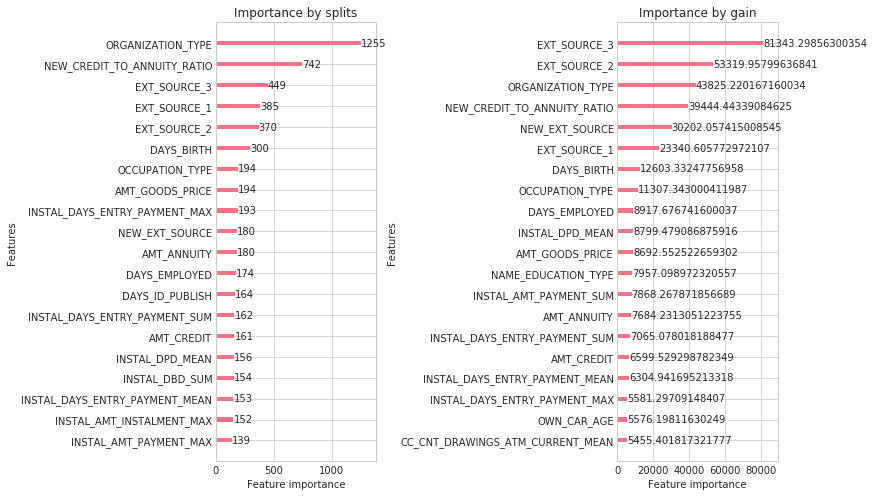

In [144]:
# Predict on test set and create submission
features_test, categorical_feats, encoder_dict = process_dataframe(input_df=features_test)
y_pred = clf.predict(features_test)
out_df = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': y_pred})
out_df.to_csv('submission.csv', index=False)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=[11, 7])
lgbm.plot_importance(clf, ax=ax, max_num_features=20, importance_type='split')
lgbm.plot_importance(clf, ax=ax1, max_num_features=20, importance_type='gain')
ax.set_title('Importance by splits')
ax1.set_title('Importance by gain')
plt.tight_layout()
plt.savefig('feature_importance.png')

## <a id='final_words'>Final Words</a>


[Back to Contents](#contents)

### <a id='summary_result'>Summary of the Results</a>


A gradient boosting framework that uses tree based learning algorithms (LightGBM) is selected for its speed and higher efficiency. Model helped to test Multiple features and parameters in a short period of time.

Additional 590 features (total: 663) extracted from 7 tables. Feature importance, extracted from the final LightGBM model was found to have a spread amongst the many features. Best peforming features are "NEW_CREDIT_ANNUITY_RATIO", "ORGANISATION_TYPE" and EXT_SOURCE as expected. Many of the most important features came from main table (Application)

Best cross validation AUC score with train data is 77.5 which is obtained with 445 boost rounds. Same model is scored 75.164 with test data (submitted to Kaggle)

### <a id='future'>Future Work</a>


[Back to Contents](#contents)

* Permutation test for feature selection can be applied to final features.
* More model can be applied to features; only 1 model used.
* KNN can be applied with different feature to group customers.
* Pipelines can be used for parameter optimisation
* Features with more variance can be extracted